In [792]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from utilities import train_test_val_split, load_matlab_data, rmse
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.stats import norm
from sklearn.base import BaseEstimator, RegressorMixin

In [793]:
x, y = load_matlab_data("data/hwkdataNEW.mat")
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y, seed=3)

In [794]:
class LocalWeightedRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel_name='gaussian', distance_name='l2', bandwidth=0.25, order=1):
        self.xscaler_ = None
        self.yscaler_ = None
        self.xs_vec_ = None
        self.ys_vec_ = None
        self.order = order
        self.bandwidth = bandwidth
        self._no_neighbors_ = []
        self.kernel_name = kernel_name
        self.distance_name = distance_name
        
        distances = {
            'l2': self.l2,
            'euclidean': self.l2,
        }
        kernels = {
            'gaussian': self.gaussian_kernel,
            'pyramid': np.vectorize(self.pyramid_kernel),
            'boxcar': np.vectorize(self.boxcar_kernel)
        }
        
        self.kernel = kernels[kernel_name]
        self.distance = distances[distance_name]
    
    def fit(self, x, y):
        self.xscaler_ = StandardScaler().fit(x)
        self.yscaler_ = StandardScaler().fit(y)
        xs = self.xscaler_.transform(x)
        ys = self.yscaler_.transform(y)
        self.xs_vec_ = xs
        self.ys_vec_ = ys
        return self
    
    def predict(self, x):
        try:
            getattr(self, 'xs_vec_')
        except AttributeError:
            raise RuntimeError("You must train before you predict...")
        
        xs = self.xscaler_.transform(x)
        xt = self.xs_vec_
        yt = self.ys_vec_
        
        # Calculate distance for every point
        d = cdist(self.xs_vec_, xs)
        assert np.all(d >= 0)
        
        # Calculate the weight for every point
        w = self.kernel(d)

        ypu = [self.lin(xs[i], w[:, i]) for i in range(xs.shape[0])]
        
        yp = self.yscaler_.inverse_transform(ypu)
         
        return yp
        
    def score(self, x, y):
        yp = self.predict(x)
        return -rmse(y, yp)
    
    def lin(self, x, w):
        l = LinearRegression(fit_intercept=True)
        #print(w.shape)
        if np.all(w == 0.0):
            self._no_neighbors_.append(x)
            d = cdist(self.xs_vec_, np.atleast_2d(x))
            return self.ys_vec_[np.argmin(d)][0]
        try:
            l.fit(self.xs_vec_, self.ys_vec_, sample_weight=w)
        except ValueError as v:
            print("Weights:")
            print(w)
            raise v
        return l.predict(x.reshape(1, -1))[0][0]
    
    # Distance measures
    def l2(self, x):
        return cdist(self.xs_vec_, x)
    
    # Kernels
    def gaussian_kernel(self, d):
        return norm.pdf(d, scale=self.bandwidth, loc=0.0)
    
    def pyramid_kernel(self, d):
        if d > self.bandwidth:
            return 0.
        else:
            return (1. - d / self.bandwidth)
    
    def boxcar_kernel(self, d):
        if d > self.bandwidth:
            return 0.
        else:
            return 1.
        
    @property
    def no_neighbors_(self):
        return np.array(self._no_neighbors_).reshape(-1, 1)

In [795]:
l = 400
f = lambda x: 10 * np.sin(x) + 3 * x + np.random.randn(l)
ft = lambda x: 10 * np.sin(x) + 3 * x
x = (np.linspace(0, 10, l) + np.random.randn(l))
y = f(x)

In [796]:
lp=100
xt = np.linspace(0, 10, lp) + np.random.randn(lp)
lwr = LocalWeightedRegression(bandwidth=0.01, kernel_name='gaussian')
lwr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

LocalWeightedRegression(bandwidth=0.01, distance_name='l2',
            kernel_name='gaussian', order=1)

In [797]:
yp = lwr.predict(xt.reshape(-1, 1))

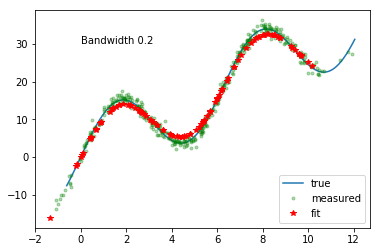

In [815]:
bw = 0.2

lp=100
xt = np.linspace(0, 10, lp) + np.random.randn(lp)
lwr = LocalWeightedRegression(bandwidth=bw, kernel_name='gaussian')
lwr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
yp = lwr.predict(xt.reshape(-1, 1))

xc = np.linspace(np.min(x1), np.max(x1), l)
plt.plot(xc, ft(xc), label="true")
plt.plot(x, y, '.', label="measured", color='g', alpha=0.3)
plt.plot(xt, yp, '*', label="fit", color='r')
plt.legend(loc="lower right")

plt.text(x=0, y=30, s=f"Bandwidth {bw}")
plt.savefig(f"lwr_{bw}.png", dpi=300)

In [786]:
scorer = make_scorer(rmse, greater_is_better=False)
params = {
    'bandwidth': (0.15, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 7.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 17.0, 20.0),
    'kernel_name': ('gaussian', 'pyramid', 'boxcar'),
    'order': (0, 1, 2)
}
grid = GridSearchCV(LocalWeightedRegression(), param_grid=params, n_jobs=-1)

In [787]:
grid.fit(xtr, ytr)

GridSearchCV(cv=None, error_score='raise',
       estimator=LocalWeightedRegression(bandwidth=0.25, distance_name='l2',
            kernel_name='gaussian', order=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bandwidth': (0.15, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 7.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 17.0, 20.0), 'kernel_name': ('gaussian', 'pyramid', 'boxcar'), 'order': (0, 1, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [788]:
grid.best_estimator_

LocalWeightedRegression(bandwidth=3.0, distance_name='l2',
            kernel_name='gaussian', order=0)

In [789]:
grid.best_score_

-83.90423501014946

In [790]:
yp = grid.predict(xts)
print(f"RMSE for this model: {rmse(yp, yts)}")

RMSE for this model: 63.61891506160178
